# HW1: Transfer Learning

Tufts CS 152 L3D, Fall 2024

Official Instructions: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html>

## Configuration

This assignment might take a while.
We recommend setting several variables here that prevent repeating long-running tasks.

In [15]:
device = 'cpu' # TODO change to GPU if you have one (e.g. on Colab)

PROB1_res_file = 'prob1_results.pkl'
PROB2_res_file = 'prob2_results.pkl'
PROB1_EXPERIMENTS = True  # Flag will skip re-running experiments if set to False
PROB1_PLOTS = True
PROB2_EXPERIMENTS = True
PROB2_PLOTS = True

# Environment setup

**Option 1: Colab**
To use this notebook with Google Colab, you will need an account and Google Drive storage (free tier just fine)

Please be sure you are *logged in* and have given requisite permission to access Drive to Google Colab.

The lines below will:

* Make folders called `CS152L3D_2024f/HW1/` in your google drive
* Clone the HW1 starter code repository there
* Note: Colab expects *this notebook* (or any notebook) will be in `Colab Notebooks/`.

That will let us use the starter code in this notebook.

**Option 2: Local**

You can also try to use your local machine (but if you don't have a GPU, this may be slow and painful.
If you choose this route, the lines below specific to Colab will just be skipped, and nothing will be done.

In [16]:
import sys
import os

In [17]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
except ImportError:
    COLAB = False

In [18]:
if COLAB:
    if not os.path.exists(os.path.join('/content/drive/MyDrive/', 'CS152L3D_2024f')):
        !cd /content/drive/MyDrive/ && mkdir CS152L3D_2024f

In [19]:
# Move notebook working directory into the folder
if COLAB:
    %cd /content/drive/MyDrive/CS152L3D_2024f/

    # Clone the repo
    if not os.path.exists('cs152l3d-24f-assignments/hw1/'):
      !git clone https://github.com/tufts-ml-courses/cs152l3d-24f-assignments

    # cd into repo
    %cd cs152l3d-24f-assignments/hw1/

Check for success. We should be able to see files like

* model.py
* data_utils.py

In [20]:
!ls

README.md                  hw1_template.tex
__pycache__                l3d_24f_cpu.yml
birdsnap10                 l3d_24f_cuda.yml
birdsnap10_224x224only.zip models.py
data_utils.py              resnet10-1253-88a5961b.pth
hw1.ipynb                  train.py
hw1.py


In [21]:
if COLAB:
    try:
        import torchinfo
        import pytorchcv
    except ImportError:
        rstr = '''
            torchinfo
            pytorchcv
            '''
        with open('colab_requirements.txt', 'w') as f:
            f.write(rstr)
        !pip install -r colab_requirements.txt
        import torchinfo
        import pytorchcv

In [22]:
DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('./birdsnap10'))
print(DATA_DIR)

/Users/joseph280996/Code/School/L3D/Assignments/hw1/birdsnap10


In [23]:
if not os.path.exists(DATA_DIR):
    !unzip birdsnap10_224x224only.zip

In [10]:
# Show contents of train set
!ls $DATA_DIR/train/

American_Black_Duck Harlequin_Duck      Prairie_Falcon      White_faced_Ibis
Golden_Eagle        Osprey              Short_eared_Owl
Great_Horned_Owl    Peregrine_Falcon    White_Ibis


# Import Libraries

In [1]:
# Import third-party library modules
import json
import pickle
import itertools
import tqdm

In [3]:
import numpy as np
import pandas as pd

In [4]:
import torchinfo
import pytorchcv
import torch
import torchvision

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8') # pretty matplotlib plots
sns.set('notebook', style='whitegrid', font_scale=1.25)

Matplotlib is building the font cache; this may take a moment.


# Import starter code modules from local files

Use **autoreload** so that any changes to these local files will be automatically reloaded into this nb

In [6]:
%load_ext autoreload
%autoreload 2

In [9]:
# Import utils from provided local starter code files
import data_utils
import models
import train

In [10]:
# Re-run this cell if you've made changes to your local file, but they aren't reflected in current nb kernel state
import importlib
importlib.reload(models);
importlib.reload(train);

# Show basic ResNet10 architecture

Load ResNet10. All layers trainable by default.

In [11]:
resnet10_in = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1)

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


Pretty-print layer-by-layer info

In [12]:
torchinfo.summary(resnet10_in, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                           Output Shape       Param #
PretrainedResNetForBirdSnap10 (PretrainedResNetForBirdSnap10)     [1, 10]            --
├─ResNet (model)                                                  [1, 10]            --
│    └─Sequential (features)                                      [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                             [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                                   [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                                   [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                                   [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                                   [1, 512, 7, 7]     (3,673,088)
│    │    └─AvgPool2d (final_pool)                                [1, 512, 1, 1]     --
│    └─Linear (output)                                            [1, 10]        

# Load dataset

In [24]:
# Verify data has been extracted correctly and is accessible to load in PyTorch
data_utils.BirdsnapDataset(DATA_DIR)

Dataset BirdsnapDataset
    Number of datapoints: 640
    Root location: /Users/joseph280996/Code/School/L3D/Assignments/hw1/birdsnap10

In [25]:
train_loader, val_loader, test_loader = data_utils.make_birdsnap_data_loaders(DATA_DIR)

splitname  0  1  2  3  4  5  6  7  8  9
    train 40 40 40 40 40 40 40 40 40 40
    valid 10 10 10 10 10 10 10 10 10 10
     test 50 50 50 50 50 50 50 50 50 50


# Problem 1 Implementation Tasks

In separate windows, you'll need to edit:

* models.py, see task (i) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>
* train.py, see tasks (ii, iii, iv) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>

Any edits to these files should *automatically* be reflected here in your active nb session, since we used **autoreload** above

Finally, as task (v), complete the implementation of `eval_acc` here to evaluate accuracy on test data

In [26]:
def eval_acc(model, device, test_loader):
    model.to(device)
    model.eval()
    correct = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)  # Move inputs and labels to the device
            logits = model(x)  # Forward pass to get predictions
            preds = torch.argmax(logits, dim=1)  # Get the predicted class
            correct += (preds == y).sum().item()  # Count the correct predictions
            # Count number of correct predictions across all batches of provided loader
    return correct / len(test_loader.dataset)

# Problem 1 Experiments

We'll now try to fit models for 2 archs (RN10, RN26) and 2 srcdatasets (ImageNet, CUB)

For each one, we'll

* keep n_trainable_layers = 1 ("last layer only" or "linear probing")
* Try to find reasonable settings of learning rate (lr), l2 penalty strength (l2pen_mag), and random seed (controls initialization and data order)

**TODO: Last-layer training of ResNet10 from ImageNet1k.**

Need to find good hyperparameters (seed, lr, l2penalty magnitude, n_epochs)

Don't peek at test, just use validation to tune.

In [32]:
import itertools

# Define hyperparameter search space
learning_rates = [0.0001, 0.001, 0.01]
l2pen_mags = [0, 0.0001, 0.001]
seeds = [42, 100, 123]
epochs = [5, 10, 30, 50, 100]

# Track best model
best_val_loss = float('inf')
best_hyperparams = None
best_model = None

# Loop through all combinations of hyperparameters
for lr, l2pen_mag, seed, epochs in itertools.product(learning_rates, l2pen_mags, seeds, epochs):
    print(f"Training with lr={lr}, l2pen_mag={l2pen_mag}, seed={seed}, epochs={epochs}")
    
    # Set the seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # Create model with specified seed
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed
    )
    
    # Train the model
    current_model, current_info = train.train_model(
        resnet10_in, device, train_loader, val_loader,
        n_epochs=epochs,
        lr=lr,
        l2pen_mag=l2pen_mag,
        data_order_seed=seed
    )
    
    # Get validation loss from training info
    val_loss = min(current_info['va']['xent'])
    
    # Update the best model if the current one is better
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = {'lr': lr, 'l2pen_mag': l2pen_mag, 'seed': seed}
        best_model = current_model

# Output the best hyperparameters and validation loss
print(f"Best validation loss: {best_val_loss}")
print(f"Best hyperparameters: {best_hyperparams}")

Training with lr=0.0001, l2pen_mag=0, seed=42
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:35<00:00,  8.98s/it, tr_xent=2.45, tr_err=0.922, va_xent=tensor(0.0488), va_err=93, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.049
best tr_err 0.922
best va_err 93.000
Training with lr=0.0001, l2pen_mag=0, seed=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:36<00:00,  9.04s/it, tr_xent=2.21, tr_err=0.807, va_xent=tensor(0.0452), va_err=88, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.045
best tr_err 0.807
best va_err 88.000
Training with lr=0.0001, l2pen_mag=0, seed=123
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:35<00:00,  8.97s/it, tr_xent=2.33, tr_err=0.833, va_xent=tensor(0.0456), va_err=84, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.046
best tr_err 0.833
best va_err 84.000
Training with lr=0.0001, l2pen_mag=0.0001, seed=42
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:35<00:00,  8.99s/it, tr_xent=2.45, tr_err=0.922, va_xent=tensor(0.0488), va_err=93, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.049
best tr_err 0.922
best va_err 93.000
Training with lr=0.0001, l2pen_mag=0.0001, seed=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:36<00:00,  9.07s/it, tr_xent=2.21, tr_err=0.807, va_xent=tensor(0.0452), va_err=88, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.045
best tr_err 0.807
best va_err 88.000
Training with lr=0.0001, l2pen_mag=0.0001, seed=123
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:36<00:00,  9.15s/it, tr_xent=2.33, tr_err=0.833, va_xent=tensor(0.0456), va_err=84, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.046
best tr_err 0.833
best va_err 84.000
Training with lr=0.0001, l2pen_mag=0.001, seed=42
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:36<00:00,  9.04s/it, tr_xent=2.45, tr_err=0.922, va_xent=tensor(0.0488), va_err=93, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.049
best tr_err 0.922
best va_err 93.000
Training with lr=0.0001, l2pen_mag=0.001, seed=100
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:37<00:00,  9.30s/it, tr_xent=2.21, tr_err=0.807, va_xent=tensor(0.0452), va_err=88, batch_done=7]


Finished after epoch 3, best epoch=3
best va_xent 0.045
best tr_err 0.807
best va_err 88.000
Training with lr=0.0001, l2pen_mag=0.001, seed=123
Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 25%|██▌       | 1/4 [00:03<00:06,  2.30s/it, tr_xent=nan, tr_err=nan, va_xent=tensor(0.0525), va_err=93, batch_done=1]

In [31]:
if PROB1_EXPERIMENTS:
    seed = 100
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)
    best_model, best_info = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=3,
        lr=0.01,
        l2pen_mag=0, # no L2 penalty on weight magnitude
        data_order_seed=seed,
        )



Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


100%|██████████| 4/4 [00:36<00:00,  9.03s/it, tr_xent=0.598, tr_err=0.217, va_xent=tensor(0.0175), va_err=25, batch_done=7]

Finished after epoch 3, best epoch=3
best va_xent 0.017
best tr_err 0.217
best va_err 25.000


# Diagnostic plot: Error/loss vs epoch

The plot below is just a demo of what you can plot. Values won't represent correct operation of model training until you run the code implementation tasks, and start training for longer (adjust n_epochs > 15).

FYI: good practices already implemented info dict returned by train_model

* Report perf on val on given initial model (epoch=0), before making any updates
* Train perf metrics only kick in for epoch 1 and later (when we are doing updates)

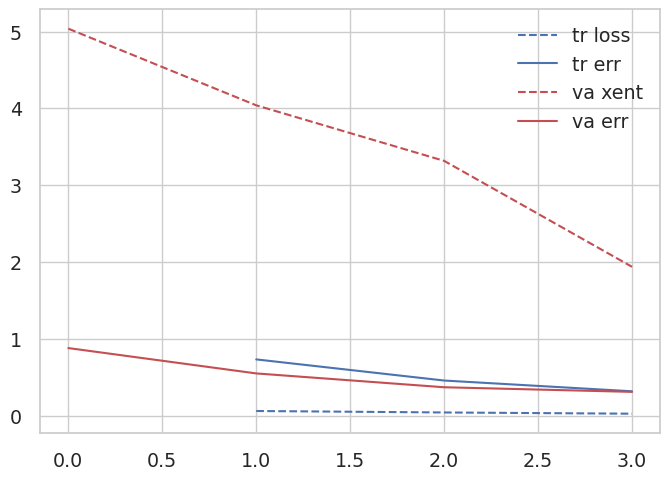

In [ ]:
plt.plot(best_info['epochs'], best_info['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info['epochs'], best_info['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info['epochs'], best_info['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info['epochs'], best_info['va']['err'], '-', color='r', label='va err')
plt.legend();

**Pro Tip:** Consider storing your "best" runs to disk, using code like below

In [ ]:
if os.path.exists(PROB1_res_file):
    with open(PROB1_res_file, 'rb') as f:
        results = pickle.load(f)
else:
    results = dict()

results[('ImageNet1k', 'ResNet10')] = best_model, best_info

with open(PROB1_res_file, 'wb') as f:
    pickle.dump(results, f)

**TODO** repeat the above for each config in ('ResNet10', 'ResNet26') and ('ImageNet1k', 'CUB')

In [ ]:
# TODO do tuning expts for Resnet10, CUB

In [ ]:
# TODO do tuning expts for Resnet26, ImageNet1k

In [ ]:
# TODO do tuning expts for Resnet26, CUB

# Problem 1 Analysis and Plotting

In [ ]:
# Create dummy results so we can show what kind of plots we want
dummy_result = {}

eps = np.arange(20)

dummy_result[('ResNet10', 'ImageNet1k')] = dict(
    lr = 0.123,
    l2pen_mag = 0.0,
    seed = 42,
    epochs=eps,
    tr=dict(
        loss=.7 - .3 * (1 - np.abs(eps-10) / 10), # upside-down triangle
        xent=.68 - .3 * (1 - np.abs(eps-10) / 10), # upside-down triangle
        err=.01 * np.ones(20),
    ),
    va=dict(
        xent=.8 - .2 * (1 - np.abs(eps-10) / 10), # upside-down triangle
        err=.1 * np.ones(20),
    ),
    best_epoch=10,
    best_va_loss=0.6,
)

In [ ]:
eps = np.arange(30)
dummy_result[('ResNet10', 'CUB')] = dict(
    lr = 0.456,
    l2pen_mag = 0.0,
    seed = 42,
    epochs=eps,
    tr=dict(
        loss=.7 - .3 * (1 - np.abs(eps-15) / 15),  # upside-down triangle
        xent=.68 - .3 * (1 - np.abs(eps-15) / 15), # upside-down triangle
        err=.01 * np.ones(30),
    ),
    va=dict(
        xent=.9 - .3 * (1 - np.abs(eps-15) / 15), # upside-down triangle
        err=.1 * np.ones(30),
    ),
    best_epoch=15,
    best_va_loss=0.6,
)

## Figure 1a: Loss over Epochs

Starter code notebook indicates style of plot desired.

**TODO** Your job is to make sure the plot shows your *real* results, not our dummy results.

TypeError: tuple indices must be integers or slices, not str

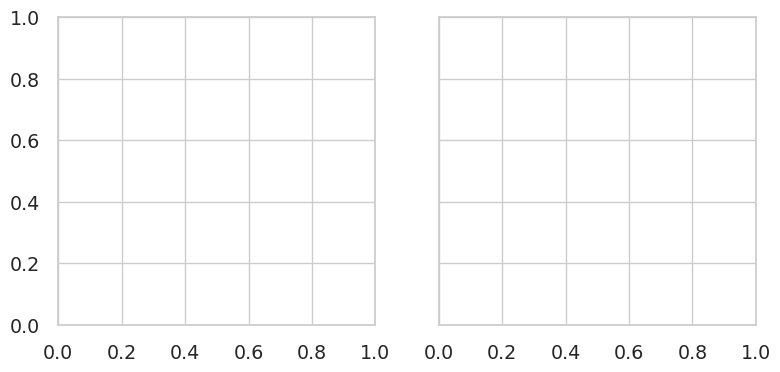

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=False)

for panel_id, (arch, src_dataset) in enumerate([
        ('ImageNet1k', 'ResNet10'),
        # ('ResNet10','CUB'),
        ]):
    ax = axgrid[panel_id]
    key = (arch, src_dataset)
    info = results[key]
    ax.plot(info['epochs'], info['va']['xent'], '--', color='r', label='va xent')
    ax.plot(info['epochs'], info['tr']['loss'], '--', color='b', label='tr loss')
    ax.plot(info['epochs'], info['va']['err'], label='va err', color='r')
    ax.plot(info['epochs'], info['tr']['err'], label='tr err', color='b')
    ax.plot(info['best_epoch'], info['best_va_loss'], '*', color='r', markersize=12, label='early stop')
    ax.set_xlabel('epoch')
    if panel_id == 0:
        ax.set_ylabel('loss per example')
    lr = info['lr']
    l2pen = info['l2pen_mag']
    seed = info['seed']
    ax.set_title(f'{arch}_{src_dataset}\nlr={lr}, l2pen={l2pen}, seed={seed}')
    ax.set_xlim([-0.001, max(info['epochs'])])

ax.set_ylim([0.0, 1.5]);
ax.legend(bbox_to_anchor=(1.55, 0.6));

## Figure 1b: Target Acc vs Source Acc

**TODO** Lookup source task accuracy (use top1 if needed) from pytorch cv webpage: https://pypi.org/project/pytorchcv/


In [ ]:
src_acc = {}
src_acc[('ResNet10', 'ImageNet1k')] = 0.5 # TODO FIXME
src_acc[('ResNet26', 'ImageNet1k')] = 0.9 # TODO FIXME

src_acc[('ResNet10', 'CUB')] = 0.5 # TODO FIXME
src_acc[('ResNet26', 'CUB')] = 0.9 # TODO FIXME

**TODO** Measure your best model accuracy using provided test_loader and `eval_acc` function, record values here

In [ ]:
tar_acc = {}
tar_acc[('ResNet10', 'ImageNet1k')] = 0.5 # TODO FIXME
tar_acc[('ResNet26', 'ImageNet1k')] = 0.9 # TODO FIXME

tar_acc[('ResNet10', 'CUB')] = 0.5 # TODO FIXME
tar_acc[('ResNet26', 'CUB')] = 0.9 # TODO FIXME

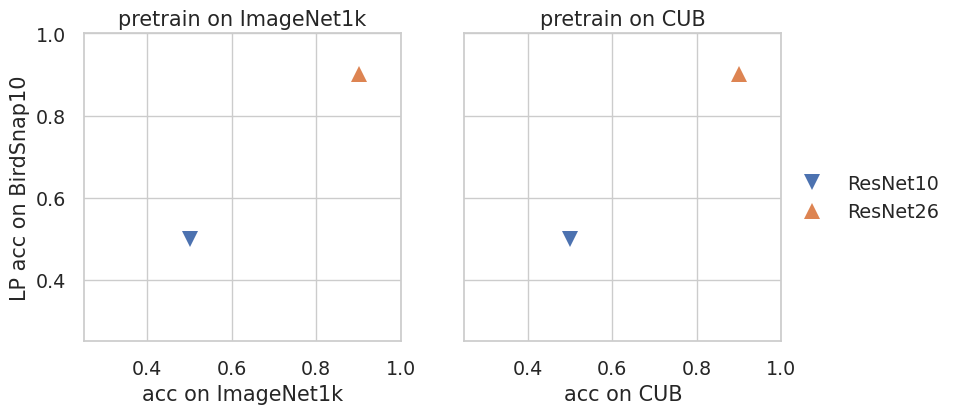

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

arch_list = ['ResNet10', 'ResNet26']
srcdata_list = ['ImageNet1k', 'CUB']

for (arch, src_dataset) in itertools.product(arch_list, srcdata_list):
    if src_dataset.count("ImageNet"):
        panel_id = 0
    else:
        panel_id = 1
    ax = axgrid[panel_id]
    ax.set_title("pretrain on " + src_dataset)
    key = "{arch}_{src_dataset}".format(arch=arch, src_dataset=src_dataset)
    cur_target_acc = tar_acc[(arch, src_dataset)]
    cur_src_acc = src_acc[(arch, src_dataset)]
    ax.plot(cur_src_acc, cur_target_acc, 'v' if arch.count('10') else '^', label=arch, markersize=12)
    ax.set_xlim([0.25, 1.0]); ax.set_xticks([.4, .6, .8, 1]);
    ax.set_ylim([0.25, 1.0]); ax.set_yticks([.4, .6, .8, 1]);
    ax.set_xlabel(f"acc on {src_dataset}");
    if panel_id == 0:
        ax.set_ylabel(f"LP acc on BirdSnap10");
plt.legend(bbox_to_anchor=(1.55, 0.6));

# Problem 2 Experiments

TODO Implement LP-then-FT, via repeated calls to **train_model**

* LP phase should use n_trainable_layers=1 (about 5000 trainable params)
* FT phase should use n_trainable_layers=3 (about 100000 trainable params)

In [ ]:
eps = np.arange(20)

P2_dummy_result = {}

# Phase 1, copy hard work from Problem 1
P2_dummy_result[('ResNet10', 'ImageNet1k','phase1')] = dummy_result[('ResNet10', 'ImageNet1k')]

eps = np.arange(20)
P2_dummy_result[('ResNet10', 'ImageNet1k','phase2')] = dict(
    lr = 0.456,
    l2pen_mag = 0.0,
    seed = 42,
    epochs=np.arange(20),
    tr=dict(
        loss=.3 - 0.15 * (eps/max(eps)),
        err=.01 * np.ones(20),
    ),
    va=dict(
        xent=.6 - 0.15 * (eps/max(eps)),
        err=.1 * np.ones(20),
    ),
    best_epoch=10,
    best_va_loss=0.6,
    test_acc=0.1,
)

## Figure 2a: Trace plots for LP then FT

We'll be looking for:

* Clear continuity in val set perf (the FT phase started at val set err rate/xent of the best LP checkpoint)
* Some kind of improvement in the FT phase, at least on train

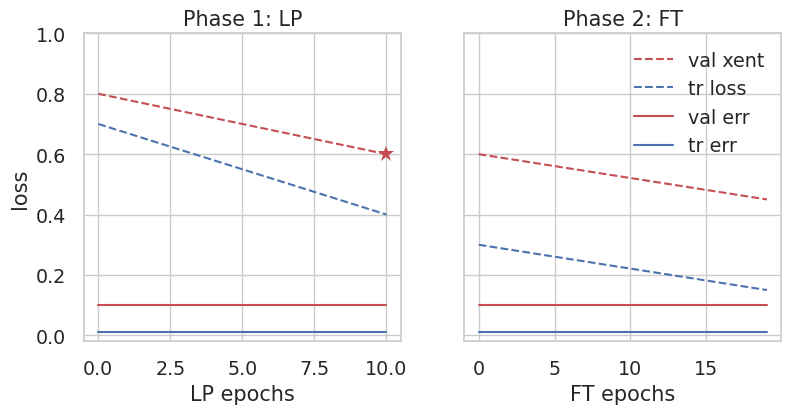

In [ ]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

LPbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase1')]
FTbest = P2_dummy_result[('ResNet10', 'ImageNet1k', 'phase2')]

# Only show LP phase until early stop occurs
eps = [e for e in LPbest['epochs'] if e <= LPbest['best_epoch']]
axgrid[0].plot(eps, LPbest['va']['xent'][:len(eps)], '--', color='r', label='val xent')
axgrid[0].plot(eps, LPbest['tr']['loss'][:len(eps)], '--', color='b')
axgrid[0].plot(eps, LPbest['va']['err'][:len(eps)], color='r', label='val')
axgrid[0].plot(eps, LPbest['tr']['err'][:len(eps)], '-', color='b')
axgrid[0].plot(LPbest['best_epoch'], LPbest['best_va_loss'], '*', color='r', markersize=12);
axgrid[0].set_title("Phase 1: LP");
axgrid[0].set_xlabel("LP epochs");
axgrid[0].set_ylabel("loss");

FTeps = FTbest['epochs']
axgrid[1].plot(FTeps, FTbest['va']['xent'], '--', color='r', label='val xent')
axgrid[1].plot(FTeps, FTbest['tr']['loss'], '--', color='b', label='tr loss')
axgrid[1].plot(FTeps, FTbest['va']['err'], '-', color='r', label='val err')
axgrid[1].plot(FTeps, FTbest['tr']['err'], '-', color='b', label='tr err')
axgrid[1].set_title("Phase 2: FT");
axgrid[1].set_ylim([-0.02, 1.]);
axgrid[1].set_xlabel('FT epochs');
axgrid[1].legend(loc='upper right');

## Problem 2b: Report test-set acc for both the phase1 and phase 2

These numbers will be presented in your report.

In [ ]:
# TODO compute test acc after the LP phase

In [ ]:
# TODO compute test acc after the FT-3 phase